In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import os
import pandas as pd
import bb
from multiprocessing import Pool

def compute_bol(slsn):
    #slsn - name of object
    # data в магнитудах
    temp = os.path.abspath(f'PTF12dam/approx_data/{slsn}.csv')
    ap_data = pd.read_csv(temp, sep=",")
    z = 0.1073

    columns = ['mjd', 'T', 'R']
    BB_parameters = pd.DataFrame(columns=columns)
    BB_parameters["mjd"] = ap_data["mjd"]
    data_size = len(ap_data)
    bb_T, bb_R = [], []
    fun = []
    succ = []
    residuals = []
    logL, sigma_logL = [], []
    
    pred_params = np.array([1.4, 0.1])
    for d in range(data_size):
        result = minimize(bb.sum_squared_err, pred_params,
                          args=(ap_data.iloc[d], z),
                          method = 'Newton-CG',
                          jac=bb.band_mag_jac,
                          hess=bb.band_mag_hess
                         )
        bb_T.append(result.x[0] * bb.const[0])
        bb_R.append(result.x[1] * bb.const[1])
        succ.append(result.success)
        fun.append(result.fun)
        pred_params = (result.x[0], result.x[1])
        residuals.append(bb.residuals(pred_params, ap_data.iloc[d], z))
        logL.append(np.log10(bb.L(pred_params)))
        sigma_logL.append(bb.sigma_logL(pred_params, ap_data.iloc[d], z))

    BB_parameters["T"], BB_parameters["R"] = bb_T, bb_R
    BB_parameters["fun"] = fun
    BB_parameters["success"] = succ
    BB_parameters['logL'] = logL
    BB_parameters['sigma_logL'] = sigma_logL
    
    res_csv = pd.DataFrame(data=np.hstack((np.array(ap_data['mjd']).reshape(-1,1), np.array(residuals))),
                           columns=['mjd'] + list(ap_data.columns)[1::2])

    BB_parameters.to_csv(f'PTF12dam/bol_output/{slsn}.csv', index=False)
    res_csv.to_csv(f'PTF12dam/bol_output/residuals/{slsn}.csv', index=False)


In [2]:
pool = Pool(processes=5)
pool.map(compute_bol, ['griB_JHK_long', 'griB_long','griB_short','ugrizB_short', 'UV_griB_JHK_short'])
pool.close()
pool.join()


In [3]:
griB_short = pd.read_csv('PTF12dam/bol_output/griB_short.csv')
griB_UV_JHK_short = pd.read_csv('PTF12dam/bol_output/UV_griB_JHK_short.csv')

griB_long = pd.read_csv('PTF12dam/bol_output/griB_long.csv')
griB_JHK_long = pd.read_csv('PTF12dam/bol_output/griB_JHK_long.csv')

ugrizB_short = pd.read_csv('PTF12dam/bol_output/ugrizB_short.csv')
all_bands_short = pd.read_csv('PTF12dam/bol_output/all_bands_short.csv')

In [16]:
def plot_luminosity(slsn, z, data, color, label):
    mjd = np.array(data["mjd"]) / (z + 1)
    logL = data['logL'] + 7
    #fig, ax = plt.subplots() #figsize=(18, 12),dpi=400
    plt.plot(mjd, logL, c=color)
    plt.fill_between(mjd, logL - data['sigma_logL'],
                         logL + data['sigma_logL'],
                        alpha=0.3, color=color, label=label)
    plt.xlabel('mjd')
    plt.ylabel('$lg_{10}L  [erg/s]$')
    plt.title(slsn)

In [17]:
z = 0.1073
mjd_vreeswijk = np.array([-78.86, -75.24, -71.68, -68.86, -66.28, -25.71, -23.76, -19.69, -17.06, -14.89,
                 -13.22, -10.37, -6.92, -5.87, -4.54, 1.44, 5.89, 8.45, 9.69, 10.39, 14.42, 19.26,
                 29.34, 40.21, 58.20, 72.52, 79.85, 105.98, 134.35, 140.65, 155.05, 168.56, 181.16, 222.56,
                 224.44, 231.57, 239.73, 246.99, 250.37, 257.69, 281.11, 334.29]) + 56096.7/ (1 + z)
L_vreeswijk = np.array([42.49, 42.54, 42.51, 42.58, 43.07, 44.21, 44.24, 44.25, 44.28, 44.29, 44.29, 
               44.31, 44.31, 44.30, 44.30, 44.28, 44.25, 44.23, 44.23, 44.22, 44.19, 44.16,
               44.07, 43.98, 43.86, 43.78, 43.72, 43.55, 43.38, 43.34, 43.24, 43.14, 43.06, 
               42.81, 42.80, 42.76, 42.71, 42.67, 42.69, 42.61, 42.47, 42.12])

err_vreeswijk = np.array([0, 0, 0, 0, 0, 0.07, 0.06, 0.09, 0.1, 0.11, 0.1, 0.09, 0.09, 0.09, 0.08,
                 0.08, 0.08, 0.08, 0.08, 0.08, 0.07, 0.09, 0.08, 0.1, 0.09, 0.1, 0.09, 0.09,
                 0.07, 0.1, 0.11, 0.13, 0.11, 0.11, 0.11, 0.12, 0.12, 0.09, 0.08, 
                 0.11, 0.15, 0.17])

(44.1, 44.58)

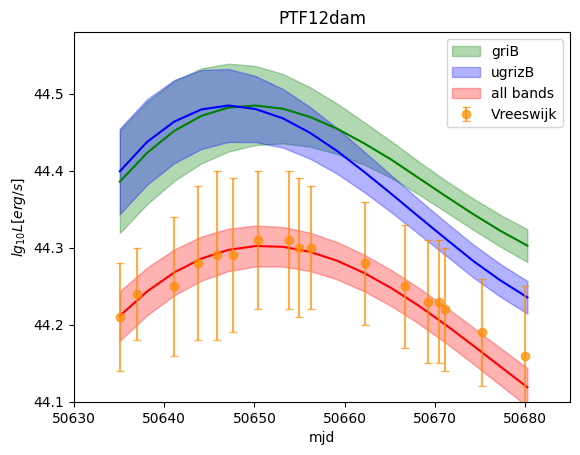

In [18]:
plot_luminosity('PTF12dam', 0.1073, griB_short, 'green', 'griB')
plot_luminosity('PTF12dam', 0.1073, ugrizB_short, 'blue', 'ugrizB')
plot_luminosity('PTF12dam', 0.1073, all_bands_short, 'red', 'all bands')


#plot_luminosity('PTF12dam', 0.1073, griB_long)
#plot_luminosity('PTF12dam', 0.1073, griB_JHK_long)

plt.errorbar(mjd_vreeswijk, L_vreeswijk,
           err_vreeswijk, fmt='o', c='darkorange',
            alpha=0.7, capsize=3, label='Vreeswijk')
plt.legend()
plt.xlim(50630, 50685)
plt.ylim(44.1, 44.58)

#plt.legend(['griB', 'griB + JHK'])


In [9]:
56471/(1+z)

50998.825973087696

In [10]:
    data = griB_long
    data_size = len(data["T"])
    L = []
    for i in range(data_size):
        L.append( bb.flux(data["T"][i])*4*np.pi*data["R"][i]**2 * 1e+7 )
    L = np.array(L)

    max_day = data["mjd"][np.argmax(L)]
    mask = (data["mjd"] <= max_day + 150)
    mjd = np.array(data["mjd"][mask]) / (z + 1)

In [10]:
res_all_short = pd.read_csv('PTF12dam/bol_output/residuals/all_bands_short.csv')

Text(0, 0.5, 'residuals^2')

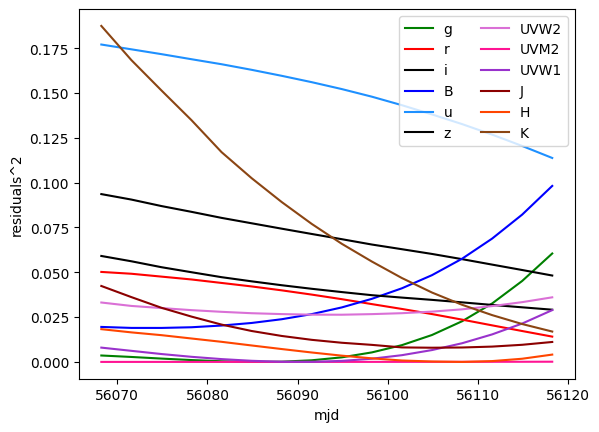

In [11]:
fig, ax = plt.subplots()
for b in res_all_short.columns[1:]:
    ax.plot(res_all_short['mjd'], res_all_short[b], label=b, c=bb.cols[b])
ax.legend(ncols=2)
ax.set_xlabel('mjd')
ax.set_ylabel('residuals^2')

## JHK predict

In [8]:
data_path = os.path.abspath('PTF12dam/bol_output/all_bands_short.csv')
data = pd.read_csv(data_path, sep=",")

data_path = os.path.abspath('PTF12dam/approx_data/all_bands_short.csv')
gp = pd.read_csv(data_path, sep=",")

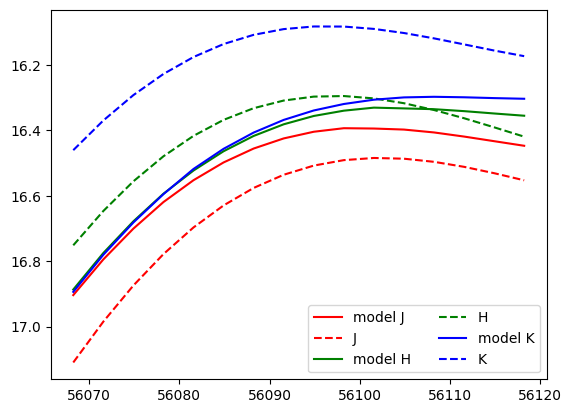

In [9]:
z = 0.1073
model_m = pd.DataFrame()
model_m["mjd"] = data['mjd']
for b in ['J','H','K']:
    temp = []
    for x in zip(data["T"]/bb.const[0], data["R"]/bb.const[1]):
        temp.append( bb.band_mag(b, x, z) )
    model_m[b] = temp

cols = dict(zip(['J','H','K'], ['red','g','b']))
fig, ax = plt.subplots()
for b in ['J','H','K']:
    ax.plot(model_m['mjd'], model_m[b], c=cols[b],label=f'model {b}')
    ax.plot(gp['mjd'], gp[b], ls='--', c=cols[b],label=b)
ax.invert_yaxis()
ax.legend(ncols=2)

In [17]:
np.ones((2,5)).T

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])